# Classifiez automatiquement des biens de consommation

Le but de projet est d'étudier la faisabilité d'un classement de biens de consommation partant d'un premier jeu de données disponible ici : 

https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip

On devra s'intéresser à une classification des données textuelles, et visuelles. Dans ce notebook on va d'abord faire étudier la classfication des données textuelles

## Phase 1 : Analyse des données textuelles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
import string
import re
import warnings
import pyLDAvis
import pyLDAvis.sklearn

from time import time

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import plot_confusion_matrix

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import UMAPVisualizer

sns.set()
%matplotlib inline
pyLDAvis.enable_notebook()

warnings.filterwarnings('ignore')

C:\Users\Salaheddine\anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\Salaheddine\anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
C:\Users\Salaheddine\anaconda3\lib\site-packages\nltk\lm\vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable
C:\Users\Salaheddine\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 

### Exploration des données

On commence par importer le CSV avec toutes les données disponibles

In [2]:
data = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv')

In [3]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [4]:
data.shape

(1050, 15)

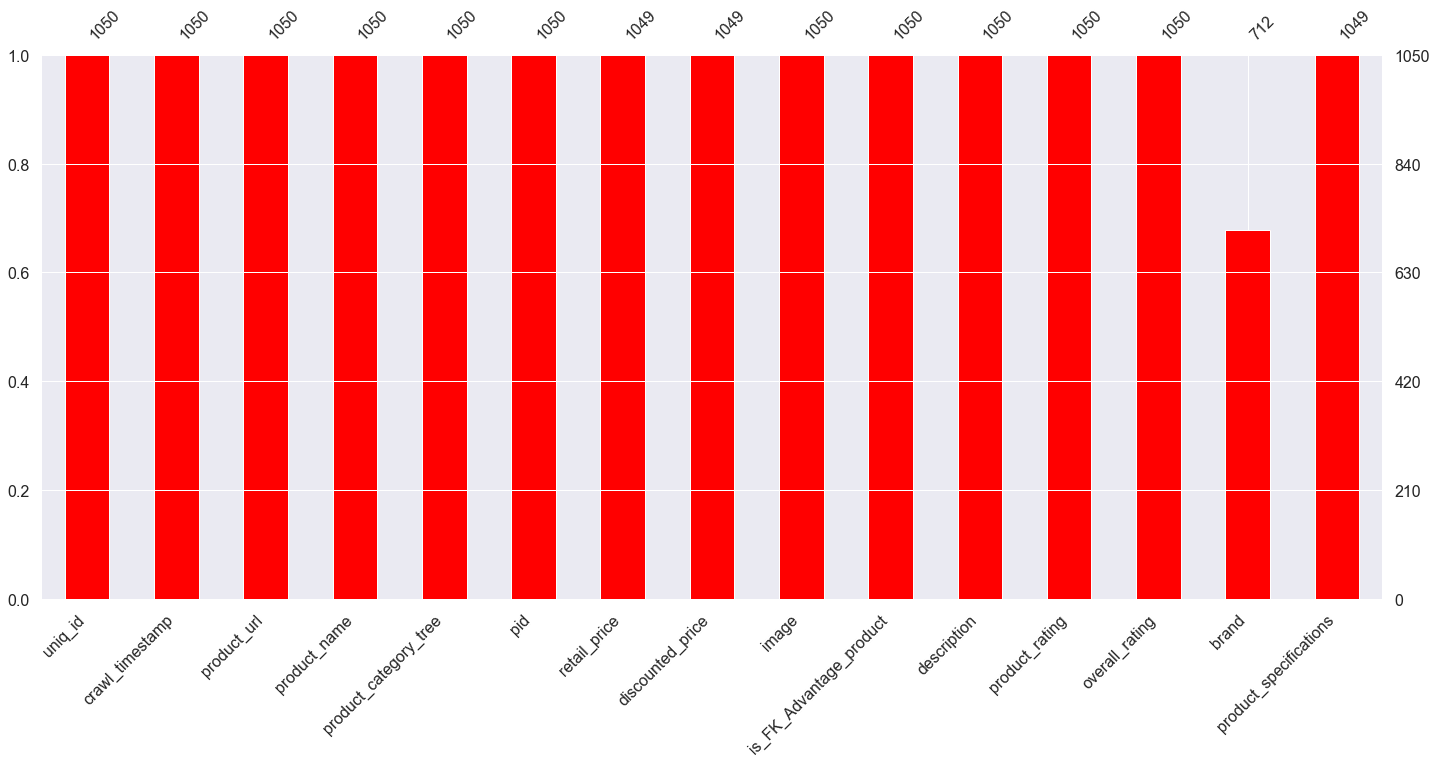

In [5]:
# On va voir les différentes colonnes qu'on possède, et ainsi que leur remplissage
msno.bar(data, color='red')

Comme il s'agit de classification de données, on va étudier une classification supervisée, on remarque qu'on a un product_category_tree qui peut contenir notre "étiquette", on va s'intéresser un peu plus à ce champ là 

In [6]:
data['product_category_tree'].unique()

array(['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]',
       '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]',
       '["Watches >> Wrist Watches >> Camerii Wrist Watches"]',
       '["Watches >> Wrist Watches >> T STAR Wrist Watches"]',
       '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]',
       '["Watches >> Wrist Watches >> T

Ca représente une arboscence de catégories, essayons de spéarer ces arborecescences pour voir les différentes catégories qui se dégagent

In [7]:
max_value = 0
for value in data['product_category_tree'].unique():
    max_value = max(len(value.split('>>')), max_value)
    
print('Maximum categoriges length {}'.format(max_value))

Maximum categoriges length 7


In [8]:
def fill_with_category(row, i):
    row_data = row['product_category_tree']
    values = row_data[2:len(row_data) - 2].split('>>') # pour éliminer les crochets avec les double quotes
    if len(values) > i:
        return values[i].strip()
    return None

for i in range(0, max_value + 1):
    data['category depth ' + str(i)] = data.apply(lambda row : fill_with_category(row, i), axis=1)

In [9]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,brand,product_specifications,category depth 0,category depth 1,category depth 2,category depth 3,category depth 4,category depth 5,category depth 6,category depth 7
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,None,None,None,None
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",None,None,None
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,None,None,None
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,None,None,None
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double B...,None,None,None


Pour chaque catégorie on va voir le  nombre d'élements qui existent dedans

In [10]:
def print_category_details(depth):
    print('Category depth {} has {} elements'.format(depth, len(data['category depth '+ str(depth)].unique())))

In [11]:
for i in range(0, max_value+1):
    print_category_details(i)

Category depth 0 has 7 elements
Category depth 1 has 62 elements
Category depth 2 has 242 elements
Category depth 3 has 350 elements
Category depth 4 has 298 elements
Category depth 5 has 118 elements
Category depth 6 has 58 elements
Category depth 7 has 1 elements


Regardons ensuite le nombre d'élements qu'on a par category

In [12]:
category_df = pd.DataFrame(data['category depth 0'].value_counts())
category_df.head(10)

,category depth 0
Computers,150
Kitchen & Dining,150
Watches,150
Home Decor & Festive Needs,150
Beauty and Personal Care,150
Home Furnishing,150
Baby Care,150


In [13]:
category_df = pd.DataFrame(data['category depth 1'].value_counts())
category_df.tail(10)

,category depth 1
Kripa's Home Furnishing,1
Consumables & Disposables,1
Candles & Fragrances,1
Men's Grooming,1
Pressure Cookers & Pans,1
Dinnerware & Crockery,1
JMD Home Furnishing,1
Strollers & Activity Gear,1
Tidy Home Furnishing,1
Beauty Accessories,1


La catégorie 1 possède quelques élements qui ne sont pas représentés, donc les catégories au dessus doivent être similaire. 
Par contre la catégorie 0 possède 150 élements par catégorie, ce qui devrait être plus intéressant pour notre étude.

On pourra toujours récupérer plus de données grâce à l'API Amazon, ou à l'API Flipkart. si  on veut étudier une catégorie plus élevée 

### Récupération des données via une API

* Une première solution serait d'utiliser l'API Amazon, 

Pour celà le plus simple est de passer par une librairie python (ou autre) déjà existente, ci dessous le code d'exemple tiré de la librairie pyaws https://pypi.org/project/pyaws/


```python
class SearchAmazonHandler(webapp.RequestHandler):
  def get(self):
    keywords=self.request.get("keywords")
    ecs.setLicenseKey('your key')
    ecs.setSecretKey('your secret key')
    # setting ResponseGroup to 'Medium' returns more info than 'Small', like a picture of the book cover
    books = ecs.ItemSearch(keywords, SearchIndex='Books', ResponseGroup='Medium')
    # for some reason, the books returned can't be sliced to reduce the number of items
    # and if I tried to send all returned books in template values, the sample hung, so I grabbed five:
    i=0
    amazon_books=[]
    while i<5:
        if books[i]:
            amazon_books.append(books[i])
        i=i+1
   
    template_values={'amazon_books':amazon_books}
    # render the page using the template engine
    path = os.path.join(os.path.dirname(__file__),'index.html')
    self.response.out.write(template.render(path,template_values))
```

* Une deuxième solution serait de requêter directement l'API Amazon en utilisant l'URL suivante : 

http://webservices.amazon.com/onca/xml?
Service=AWSECommerceService&
AWSAccessKeyId=[AWS Access Key ID]&
AssociateTag=[Associate ID]&
Operation=ItemSearch&
VariationPage=1&
Sort=salesrank&
Keywords=[Product description / name]& # optional
SearchIndex=[Category du produit]& # optional
Signature=[Tracker Id de la requete]


On aura juste besoin de changer dans l'URL les noms entre crochets, pour mettre le bon Key id / associate id, et le nom du produit ou la catégorie qu'on cherche, par exemple pour chercher les description du livre le seigneur des anneaux, le search index serait Books, (pas obligatoire comme paramètre)


* Enfin une troisième solution serait d'utiliser l'api flipkart, vu que le jeu de test est récupéré de Flipkart

La documentation pour lister les produits est disponible ici : https://affiliate.flipkart.com/api-docs/af_prod_ref.html

### Nettoyage des données


On va s'intéresser du coup à la première strate de catégories, la category depth 0, on pourra s'intéresser à d'autres catégories en ayant plus de données

In [14]:
data.rename(columns={'category depth 0': 'main category'}, inplace=True)
data.shape

(1050, 23)

In [15]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,brand,product_specifications,main category,category depth 1,category depth 2,category depth 3,category depth 4,category depth 5,category depth 6,category depth 7
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,None,None,None,None
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",None,None,None
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,None,None,None
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,None,None,None
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double B...,None,None,None


In [16]:
data.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications', 'main category',
       'category depth 1', 'category depth 2', 'category depth 3',
       'category depth 4', 'category depth 5', 'category depth 6',
       'category depth 7'],
      dtype='object')

In [17]:
# on enlève toutes les colonnes qui vont pas nous servir, on gardera juste l'image, la description et la catgoérie cible<

data_cleaned = data.drop(columns=['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
                                  'product_category_tree', 'pid', 'retail_price', 'discounted_price',
                                  'is_FK_Advantage_product', 'product_rating', 'overall_rating', 'brand', 
                                  'product_specifications', 'category depth 1', 'category depth 2', 
                                  'category depth 3', 'category depth 4', 'category depth 5', 'category depth 6',
                                  'category depth 7'])

In [18]:
data_cleaned.reset_index(inplace=True, drop=True)
data_cleaned.head()

,image,description,main category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


In [19]:
# On sauve les données nettoyées pouro qu'elles soient utilisées par l'analyse visuelle aussi 
data_cleaned.to_feather('data.ft')

### Bag Of Words

On va utiliser pour commencer les stop words par défaut, avec la ponctuation, ainsi qu'un snowball stemmer 

In [20]:
stop_words = set(stopwords.words('english')) 
stop_words.update(string.punctuation)
# Use NLTK's SnowballStemmer
stemmer = SnowballStemmer('english', ignore_stopwords=True)
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z]", " ", str_input).lower().split()
    words = [stemmer.stem(word) for word in words]
    return words


In [21]:
# on va compter  le nombre d'occurences qu'on a par mot  dans toutes les descriptions confondues
all_words = {}
for desc in data_cleaned['description']:
    words= stemming_tokenizer(desc)
    for word in words:
        if not(word in stop_words):
            count = all_words.get(word, 0)
            all_words[word] = count + 1

In [22]:
from collections import Counter
counter = Counter(all_words)

In [23]:
counter.most_common(50)

[('rs', 911),
 ('product', 870),
 ('free', 618),
 ('buy', 581),
 ('replac', 570),
 ('ship', 569),
 ('deliveri', 567),
 ('genuin', 564),
 ('cash', 564),
 ('price', 561),
 ('cm', 558),
 ('day', 553),
 ('flipkart', 481),
 ('com', 473),
 ('guarante', 473),
 ('mug', 457),
 ('featur', 408),
 ('design', 401),
 ('onlin', 396),
 ('specif', 380),
 ('color', 380),
 ('watch', 360),
 ('pack', 342),
 ('type', 325),
 ('set', 324),
 ('babi', 321),
 ('materi', 313),
 ('cotton', 299),
 ('box', 297),
 ('print', 291),
 ('general', 288),
 ('packag', 278),
 ('sale', 262),
 ('analog', 262),
 ('number', 254),
 ('warranti', 252),
 ('brand', 247),
 ('detail', 246),
 ('qualiti', 245),
 ('girl', 242),
 ('inch', 239),
 ('laptop', 236),
 ('best', 230),
 ('key', 228),
 ('model', 226),
 ('gift', 220),
 ('ceram', 219),
 ('fabric', 211),
 ('cover', 209),
 ('showpiec', 207)]

En analysant un peu plus les mots on trouve que certains sont trop commun, comme buy, com, flipkart .... On va rajouter ces mots là à notre univers de stopwords

In [24]:
stop_words.update(['flipkart', 'com', 'buy', 'rs', 'product', 'day', 'cm', 'delivery', 'free', 'cash', 'price', 'online', 'replac', 'deliveri', 
                  'genuin', 'ship', 'day', 'guarantee', 'onlin', 'feature', 'specif', 'print', 'detail', 'best', 'great', 'perfect', 'inch', 
                  'guarante', 'featur', 'set', 'color', 'pack', 'qualiti', 'sale', 'number', 'brand', 'gift', 'model', 'x', 'use', 'made', 'l'])

In [25]:
# on fait un train test split dans le but d'évaluer la pertinence de notre modèle plus tard
X_train, X_test, y_train, y_test = train_test_split(data_cleaned['description'], data_cleaned['main category'], test_size = 0.2, random_state=42)

In [26]:
# On va construire nore bag of words en utilisant le snowball stemmer, et l'univers de stop words updaté
cv = CountVectorizer(encoding='utf-8',
                     lowercase=True, 
                     stop_words=stop_words, 
                     tokenizer=stemming_tokenizer)
 
word_count_vector=cv.fit_transform(X_train)

In [27]:
# Regardons à quoi ressemblent nos données sur une des lignes

df = pd.DataFrame(word_count_vector[0].T.todense(), index=cv.get_feature_names(), columns=['count'])
df.sort_values(by=['count'],ascending=False,inplace=True)
df[df['count'] > 0]

,count
n,3
analog,2
men,2
timewel,2
watch,2
discount,1
india,1


In [28]:
X_train[0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [29]:
print(stemming_tokenizer(X_train[0]))

['key', 'featur', 'of', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'in', 'height', 'pack', 'of', 'price', 'rs', 'this', 'curtain', 'enhanc', 'the', 'look', 'of', 'the', 'interior', 'this', 'curtain', 'is', 'made', 'from', 'high', 'qualiti', 'polyest', 'fabric', 'it', 'featur', 'an', 'eyelet', 'style', 'stitch', 'with', 'metal', 'ring', 'it', 'make', 'the', 'room', 'environ', 'romant', 'and', 'love', 'this', 'curtain', 'is', 'ant', 'wrinkl', 'and', 'anti', 'shrinkag', 'and', 'have', 'eleg', 'appar', 'give', 'your', 'home', 'a', 'bright', 'and', 'modernist', 'appeal', 'with', 'these', 'design', 'the', 'surreal', 'attent', 'is', 'sure', 'to', 'steal', 'heart', 'these', 'contemporari', 'eyelet', 'and', 'valanc', 'curtain', 'slide', 'smooth', 'so', 'when', 'you', 'draw', 'them', 'apart', 'first', 'thing', 'in', 'the', 'morn', 'to', 'welcom', 'the', 'bright', 's

On devine facilement que ça correspond  la description d'une montre analogue

In [30]:
results_df = pd.DataFrame(word_count_vector.A, columns=cv.get_feature_names())

In [31]:
results_df.head()

,aa,aaa,aapno,aari,aarika,abil,abkl,abl,abod,abras,...,yves,yx,zaicus,zero,zikrak,zip,zipper,zone,zora,zyxel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


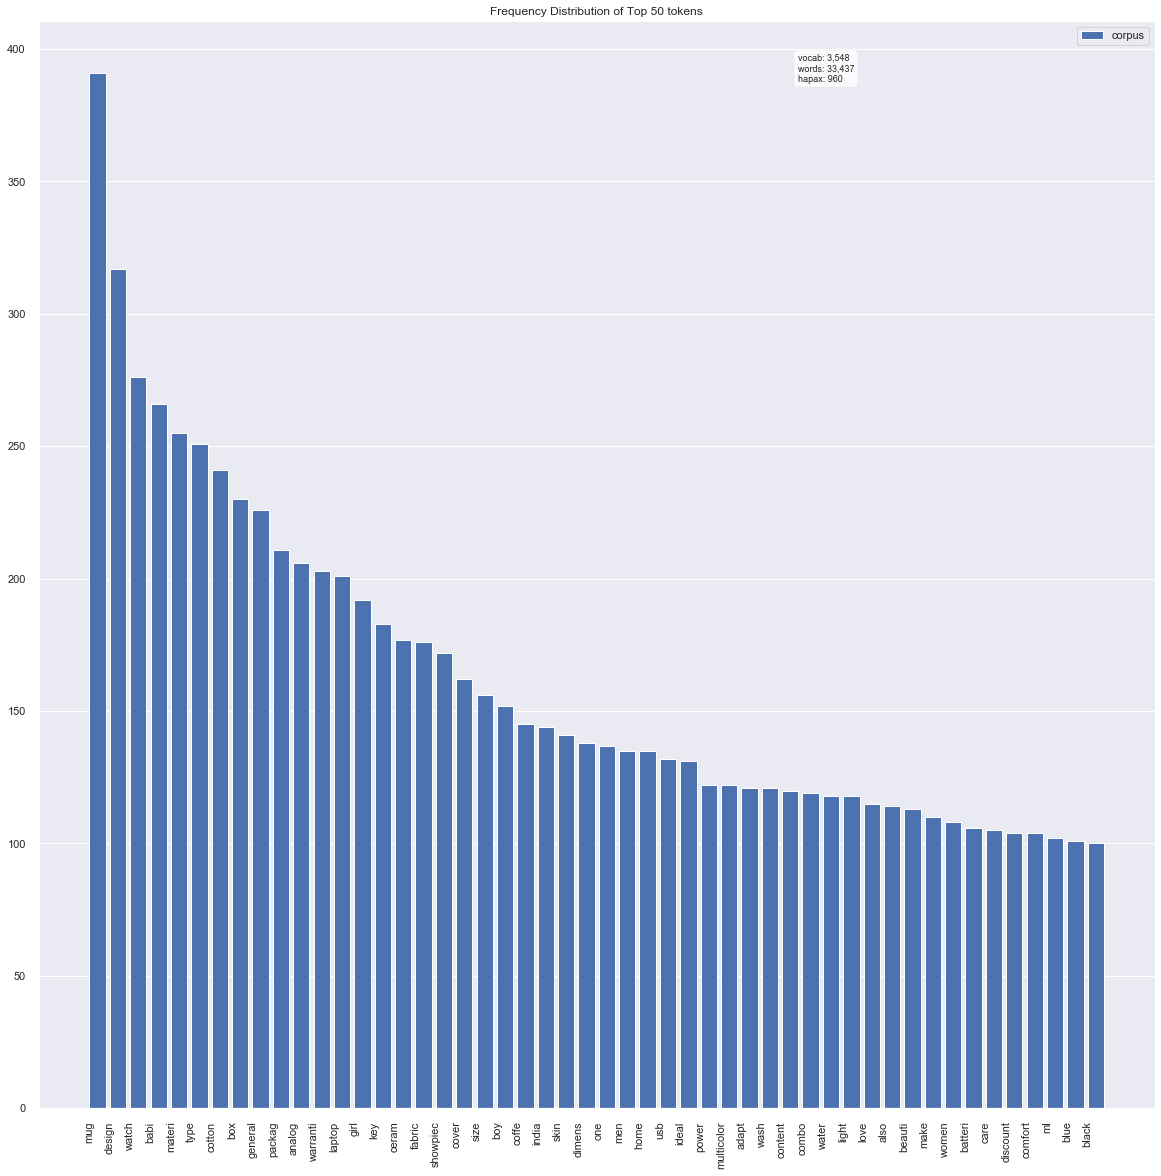

In [32]:
fig, ax = plt.subplots(figsize=(20, 20))
visualizer = FreqDistVisualizer(features=cv.get_feature_names(), orient='v', ax=ax)
visualizer.fit(word_count_vector)
visualizer.show()

### Utilisation du TF-IDF

In [33]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True, 
                                 encoding='utf-8',
                                 lowercase=True, 
                                 tokenizer=stemming_tokenizer,
                                 stop_words=stop_words)
 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(X_train)


On va d'abord visualiser nos données par UMAP

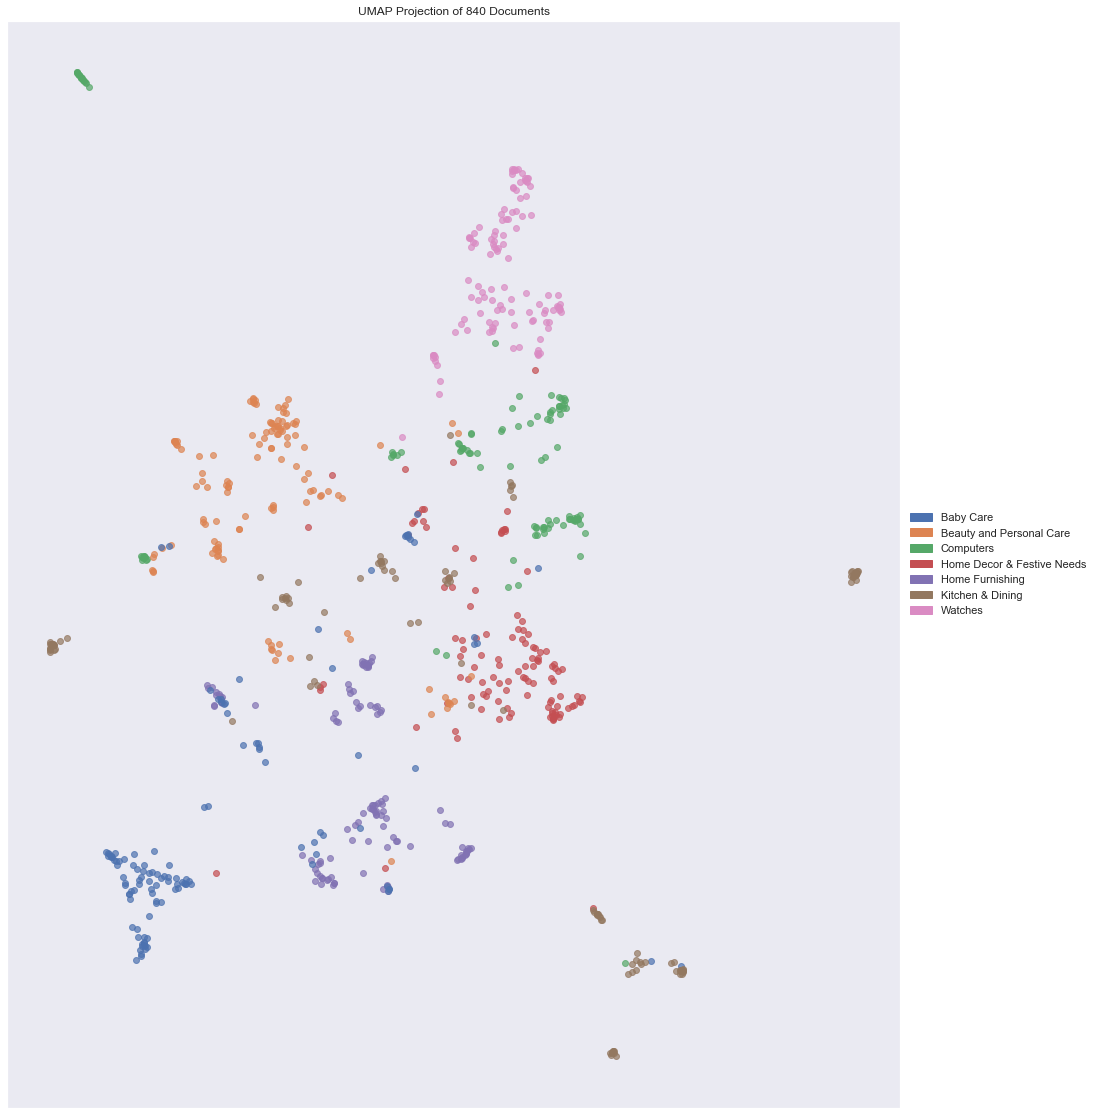

In [34]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

fig, ax = plt.subplots(figsize=(20, 20))
tsne = UMAPVisualizer(labels=set(list(y_train)), ax=ax)
tsne.fit(tfidf_vectorizer_vectors, y_train)
tsne.show()

Regardons ce que ça donne sur la première données

In [35]:
df = pd.DataFrame(tfidf_vectorizer_vectors[0].T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=['count'])
df.sort_values(by=['count'],ascending=False,inplace=True)
df[df['count'] > 0]

,count
n,0.621586
timewel,0.540787
men,0.337555
analog,0.295508
watch,0.281823
discount,0.147296
india,0.137084


### Utilisation de la NMF

In [36]:
nmf = NMF(n_components = data['main category'].nunique(),
          random_state=42,
          alpha=.1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000,
          l1_ratio=.5).fit(tfidf_vectorizer_vectors)

In [37]:
# on va jste imprimer les topics qui se dégagent de notre NMF
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [38]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words = 10)

Topic #0: mug ceram coffe ml prithish tea one love design get
Topic #1: watch analog men india women discount dial strap sonata maxima
Topic #2: babi cotton girl fabric dress ideal boy general content neck
Topic #3: craft rockmantra come fresh ensur exclus creation year design yet
Topic #4: singl abstract blanket doubl multicolor comfort quilt cover cushion floral
Topic #5: combo laptop usb warranti batteri skin led power cell light
Topic #6: showpiec towel kadhai sticker bath brass n router decor handicraft



### Utilisation d'une LDA

In [39]:
lda = LatentDirichletAllocation(n_components=data['main category'].nunique(),
                                random_state=42, 
                                n_jobs=-1,
                                evaluate_every=1,
                                max_iter=100,
                                learning_offset=10,
                                learning_decay=0.5)
lda.fit(tfidf_vectorizer_vectors)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=1, learning_decay=0.5,
                          learning_method='batch', learning_offset=10,
                          max_doc_update_iter=100, max_iter=100,
                          mean_change_tol=0.001, n_components=7, n_jobs=-1,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [40]:
print_top_words(lda, tfidf_feature_names, n_top_words = 10)

Topic #0: curtain tenda eyelet polyest door n combo hair skin kadhai
Topic #1: kadhai timewel pp lamp kalash runner hub link tabl combo
Topic #2: mug design cover showpiec multicolor warranti ceram box home cushion
Topic #3: combo quilt showpiec comfort singl floral jewelleri handicraft playboy abstract
Topic #4: usb led light bottl bulb power flexibl nutcas portabl showpiec
Topic #5: laptop coffe mug cell pc hp batteri dv skin pavilion
Topic #6: watch analog babi men girl cotton boy discount women india



In [41]:
# on va utiliser pyLDAvis pour visualiser ces données
pyLDAvis.sklearn.prepare(lda, tfidf_vectorizer_vectors, tfidf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6     -29.594002  60.112713       1        1  28.098273
2     -45.996586  11.891685       2        1  25.296206
5      20.368856  70.019325       3        1  11.326172
0      53.928768  31.704309       4        1  10.078630
4     -12.437127 -26.423267       5        1   9.375896
3       3.965971  21.797720       6        1   8.503728
1      37.524284 -16.517805       7        1   7.321095, topic_info=        Term       Freq      Total Category  logprob  loglift
3420   watch  15.000000  15.000000  Default  30.0000  30.0000
112   analog  12.000000  12.000000  Default  29.0000  29.0000
231     babi  11.000000  11.000000  Default  28.0000  28.0000
1946     men   8.000000   8.000000  Default  27.0000  27.0000
1307    girl   8.000000   8.000000  Default  26.0000  26.0000
...      ...        ...        ...      ...      ...      ...
629    combo   0.465408   7.984222   Topic7  -6.1454  -0.2279
2158   offer   0.311744   1.522488   Topic7  -6.5461   1.0285
3315     usb   0.346090   4.332851   Topic7  -6.4416   0.0871
393    brass   0.323513   3.495538   Topic7  -6.5091   0.2344
1489    hous   0.307320   1.923808   Topic7  -6.5604   0.7802

[357 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
12        1  0.318426  abstract
12        2  0.477639  abstract
12        6  0.159213  abstract
35        2  0.692244     adapt
43        6  0.870804     adida
...     ...       ...       ...
3504      1  0.647144      wrap
3504      5  0.647144      wrap
3521      6  0.859843   yardley
3527      1  0.733224       yet
3532      1  0.888026        ym

[311 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 6, 1, 5, 4, 2])

### Tests de classifications

On a va utiliser un pipeline dans lequel on va faire une transformation idf, + une classification (SVC, puis LogisticRegression puis SGD) et on va voir si on arrive à classer les données actuelles
On va faire aussi un grid search pour trouver les meilleurs paramètres

In [42]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC())
])

parameters = {
    'vect__tokenizer': (stemming_tokenizer,),
    'vect__encoding': ('utf-8',),
    'vect__lowercase': (True,),
    'vect__stop_words': (stop_words, ),
    'vect__max_df': (0.7, 0.8, 0.9, 1.0),
    'vect__min_df': (0.001, 0.01, 0.1, 1),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__C': np.linspace(0.1,1,5),
}



def estimate(parameters, pipeline):
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=KFold(n_splits=3))

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best cross validation score: %0.3f" % grid_search.best_score_)
    print("Training set score: %0.3f" % grid_search.best_estimator_.score(X_train, y_train))
    print("Testing set score: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return grid_search.best_estimator_

In [43]:
best_svc_estimator = estimate(parameters, pipeline)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__tokenizer': (<function stemming_tokenizer at 0x0000018455B63C18>,), 'vect__encoding': ('utf-8',), 'vect__lowercase': (True,), 'vect__stop_words': ({'a', 'com', 'each', 'be', 'whom', 'hers', 'here', 'should', 'rs', 'these', 'so', 'very', 'feature', 'or', "it's", 'itself', '}', '`', 'weren', 'over', 'y', '!', 'detail', 'himself', 'the', 'few', 'isn', "hasn't", 'deliveri', 'is', 'being', 'brand', 'most', 'yours', "that'll", 'replac', '>', 'there', "'", 'in', 'ma', "shan't", "should've", 'after', 'same', 'were', 'about', 'at', 'will', '*', '<', '[', 'yourself', '~', "shouldn't", 'you', '.', "aren't", '(', 'only', 'i', 't', 'won', 'mightn', 'flipkart', 'd', "doesn't", 'made', 'x', 'do', '"', ':', 'needn', 'during', 'than', "wouldn't", 'myself', '|', 'shouldn', ';', '\\', 'price', 'was', "don't", 'free', 'for', 'just', 'this', 'great', 'been', 'down', '?', "haven't", 'doing', 'by', 'they', 'his', 'their', 'until

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 10.4min finished


done in 623.311s

Best cross validation score: 0.926
Training set score: 0.999
Testing set score: 0.948
Best parameters set:
	clf__C: 1.0
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__encoding: 'utf-8'
	vect__lowercase: True
	vect__max_df: 0.7
	vect__min_df: 0.001
	vect__ngram_range: (1, 1)
	vect__stop_words: {'a', 'com', 'each', 'be', 'whom', 'hers', 'here', 'should', 'rs', 'these', 'so', 'very', 'feature', 'or', "it's", 'itself', '}', '`', 'weren', 'over', 'y', '!', 'detail', 'himself', 'the', 'few', 'isn', "hasn't", 'deliveri', 'is', 'being', 'brand', 'most', 'yours', "that'll", 'replac', '>', 'there', "'", 'in', 'ma', "shan't", "should've", 'after', 'same', 'were', 'about', 'at', 'will', '*', '<', '[', 'yourself', '~', "shouldn't", 'you', '.', "aren't", '(', 'only', 'i', 'flipkart', 't', 'won', 'mightn', "doesn't", 'd', 'made', 'x', 'do', '"', ':', 'needn', 'during', 'than', "wouldn't", 'myself', '|', 'shouldn', ';', '\\', 'price', 'was', "don't", 'free', 'for', 'just', 'this', '

In [44]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])

parameters = {
    'vect__tokenizer': (stemming_tokenizer,),
    'vect__encoding': ('utf-8',),
    'vect__lowercase': (True,),
    'vect__stop_words': (stop_words, ),
    'vect__max_df': (0.7, 0.8, 0.9, 1.0),
    'vect__min_df': (0.001, 0.01, 0.1, 1),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__C': np.linspace(0.1,1,5),
}
best_lr_estimator = estimate(parameters, pipeline)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__tokenizer': (<function stemming_tokenizer at 0x0000018455B63C18>,), 'vect__encoding': ('utf-8',), 'vect__lowercase': (True,), 'vect__stop_words': ({'a', 'com', 'each', 'be', 'whom', 'hers', 'here', 'should', 'rs', 'these', 'so', 'very', 'feature', 'or', "it's", 'itself', '}', '`', 'weren', 'over', 'y', '!', 'detail', 'himself', 'the', 'few', 'isn', "hasn't", 'deliveri', 'is', 'being', 'brand', 'most', 'yours', "that'll", 'replac', '>', 'there', "'", 'in', 'ma', "shan't", "should've", 'after', 'same', 'were', 'about', 'at', 'will', '*', '<', '[', 'yourself', '~', "shouldn't", 'you', '.', "aren't", '(', 'only', 'i', 't', 'won', 'mightn', 'flipkart', 'd', "doesn't", 'made', 'x', 'do', '"', ':', 'needn', 'during', 'than', "wouldn't", 'myself', '|', 'shouldn', ';', '\\', 'price', 'was', "don't", 'free', 'for', 'just', 'this', 'great', 'been', 'down', '?', "haven't", 'doing', 'by', 'they', 'his', 'their', 'until

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 10.8min finished


done in 649.483s

Best cross validation score: 0.925
Training set score: 0.986
Testing set score: 0.962
Best parameters set:
	clf__C: 1.0
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__encoding: 'utf-8'
	vect__lowercase: True
	vect__max_df: 0.7
	vect__min_df: 0.001
	vect__ngram_range: (1, 1)
	vect__stop_words: {'a', 'com', 'each', 'be', 'whom', 'hers', 'here', 'should', 'rs', 'these', 'so', 'very', 'feature', 'or', "it's", 'itself', '}', '`', 'weren', 'over', 'y', '!', 'detail', 'himself', 'the', 'few', 'isn', "hasn't", 'deliveri', 'is', 'being', 'brand', 'most', 'yours', "that'll", 'replac', '>', 'there', "'", 'in', 'ma', "shan't", "should've", 'after', 'same', 'were', 'about', 'at', 'will', '*', '<', '[', 'yourself', '~', "shouldn't", 'you', '.', "aren't", '(', 'only', 'i', 'flipkart', 't', 'won', 'mightn', "doesn't", 'd', 'made', 'x', 'do', '"', ':', 'needn', 'during', 'than', "wouldn't", 'myself', '|', 'shouldn', ';', '\\', 'price', 'was', "don't", 'free', 'for', 'just', 'this', '

In [45]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())
])

parameters = {
    'vect__tokenizer': (stemming_tokenizer,),
    'vect__encoding': ('utf-8',),
    'vect__lowercase': (True,),
    'vect__stop_words': (stop_words, ),
    'vect__max_df': (0.7, 0.8, 0.9, 1.0),
    'vect__min_df': (0.001, 0.01, 0.1, 1),
    'vect__ngram_range': ((1, 1), ),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__early_stopping': (True,),
    'clf__penalty': ('l2', 'elasticnet'),
}
best_sgd_estimator = estimate(parameters, pipeline)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__tokenizer': (<function stemming_tokenizer at 0x0000018455B63C18>,), 'vect__encoding': ('utf-8',), 'vect__lowercase': (True,), 'vect__stop_words': ({'a', 'com', 'each', 'be', 'whom', 'hers', 'here', 'should', 'rs', 'these', 'so', 'very', 'feature', 'or', "it's", 'itself', '}', '`', 'weren', 'over', 'y', '!', 'detail', 'himself', 'the', 'few', 'isn', "hasn't", 'deliveri', 'is', 'being', 'brand', 'most', 'yours', "that'll", 'replac', '>', 'there', "'", 'in', 'ma', "shan't", "should've", 'after', 'same', 'were', 'about', 'at', 'will', '*', '<', '[', 'yourself', '~', "shouldn't", 'you', '.', "aren't", '(', 'only', 'i', 't', 'won', 'mightn', 'flipkart', 'd', "doesn't", 'made', 'x', 'do', '"', ':', 'needn', 'during', 'than', "wouldn't", 'myself', '|', 'shouldn', ';', '\\', 'price', 'was', "don't", 'free', 'for', 'just', 'this', 'great', 'been', 'down', '?', "haven't", 'doing', 'by', 'they', 'his', 'their', 'until

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:  3.8min finished


done in 231.729s

Best cross validation score: 0.943
Training set score: 0.993
Testing set score: 0.957
Best parameters set:
	clf__alpha: 1e-05
	clf__early_stopping: True
	clf__max_iter: 20
	clf__penalty: 'l2'
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__encoding: 'utf-8'
	vect__lowercase: True
	vect__max_df: 0.9
	vect__min_df: 0.001
	vect__ngram_range: (1, 1)
	vect__stop_words: {'a', 'com', 'each', 'be', 'whom', 'hers', 'here', 'should', 'rs', 'these', 'so', 'very', 'feature', 'or', "it's", 'itself', '}', '`', 'weren', 'over', 'y', '!', 'detail', 'himself', 'the', 'few', 'isn', "hasn't", 'deliveri', 'is', 'being', 'brand', 'most', 'yours', "that'll", 'replac', '>', 'there', "'", 'in', 'ma', "shan't", "should've", 'after', 'same', 'were', 'about', 'at', 'will', '*', '<', '[', 'yourself', '~', "shouldn't", 'you', '.', "aren't", '(', 'only', 'i', 'flipkart', 't', 'won', 'mightn', "doesn't", 'd', 'made', 'x', 'do', '"', ':', 'needn', 'during', 'than', "wouldn't", 'myself', '|', 'should

On va opter pour le SGD, qui donne un score de validation croisée de 0.94

In [46]:
y_pred = best_sgd_estimator.predict(X_test)

In [47]:
for i,j in zip(y_pred, y_test):
    if i!= j:
        print('predicted {}, got {}'.format(i, j))

predicted Watches, got Computers
predicted Baby Care, got Home Furnishing
predicted Baby Care, got Home Furnishing
predicted Computers, got Home Decor & Festive Needs
predicted Kitchen & Dining, got Baby Care
predicted Home Decor & Festive Needs, got Baby Care
predicted Beauty and Personal Care, got Home Decor & Festive Needs
predicted Beauty and Personal Care, got Baby Care
predicted Home Furnishing, got Baby Care


On va  utiliser une matrice de confusion pour voir là ou on s'est trompé

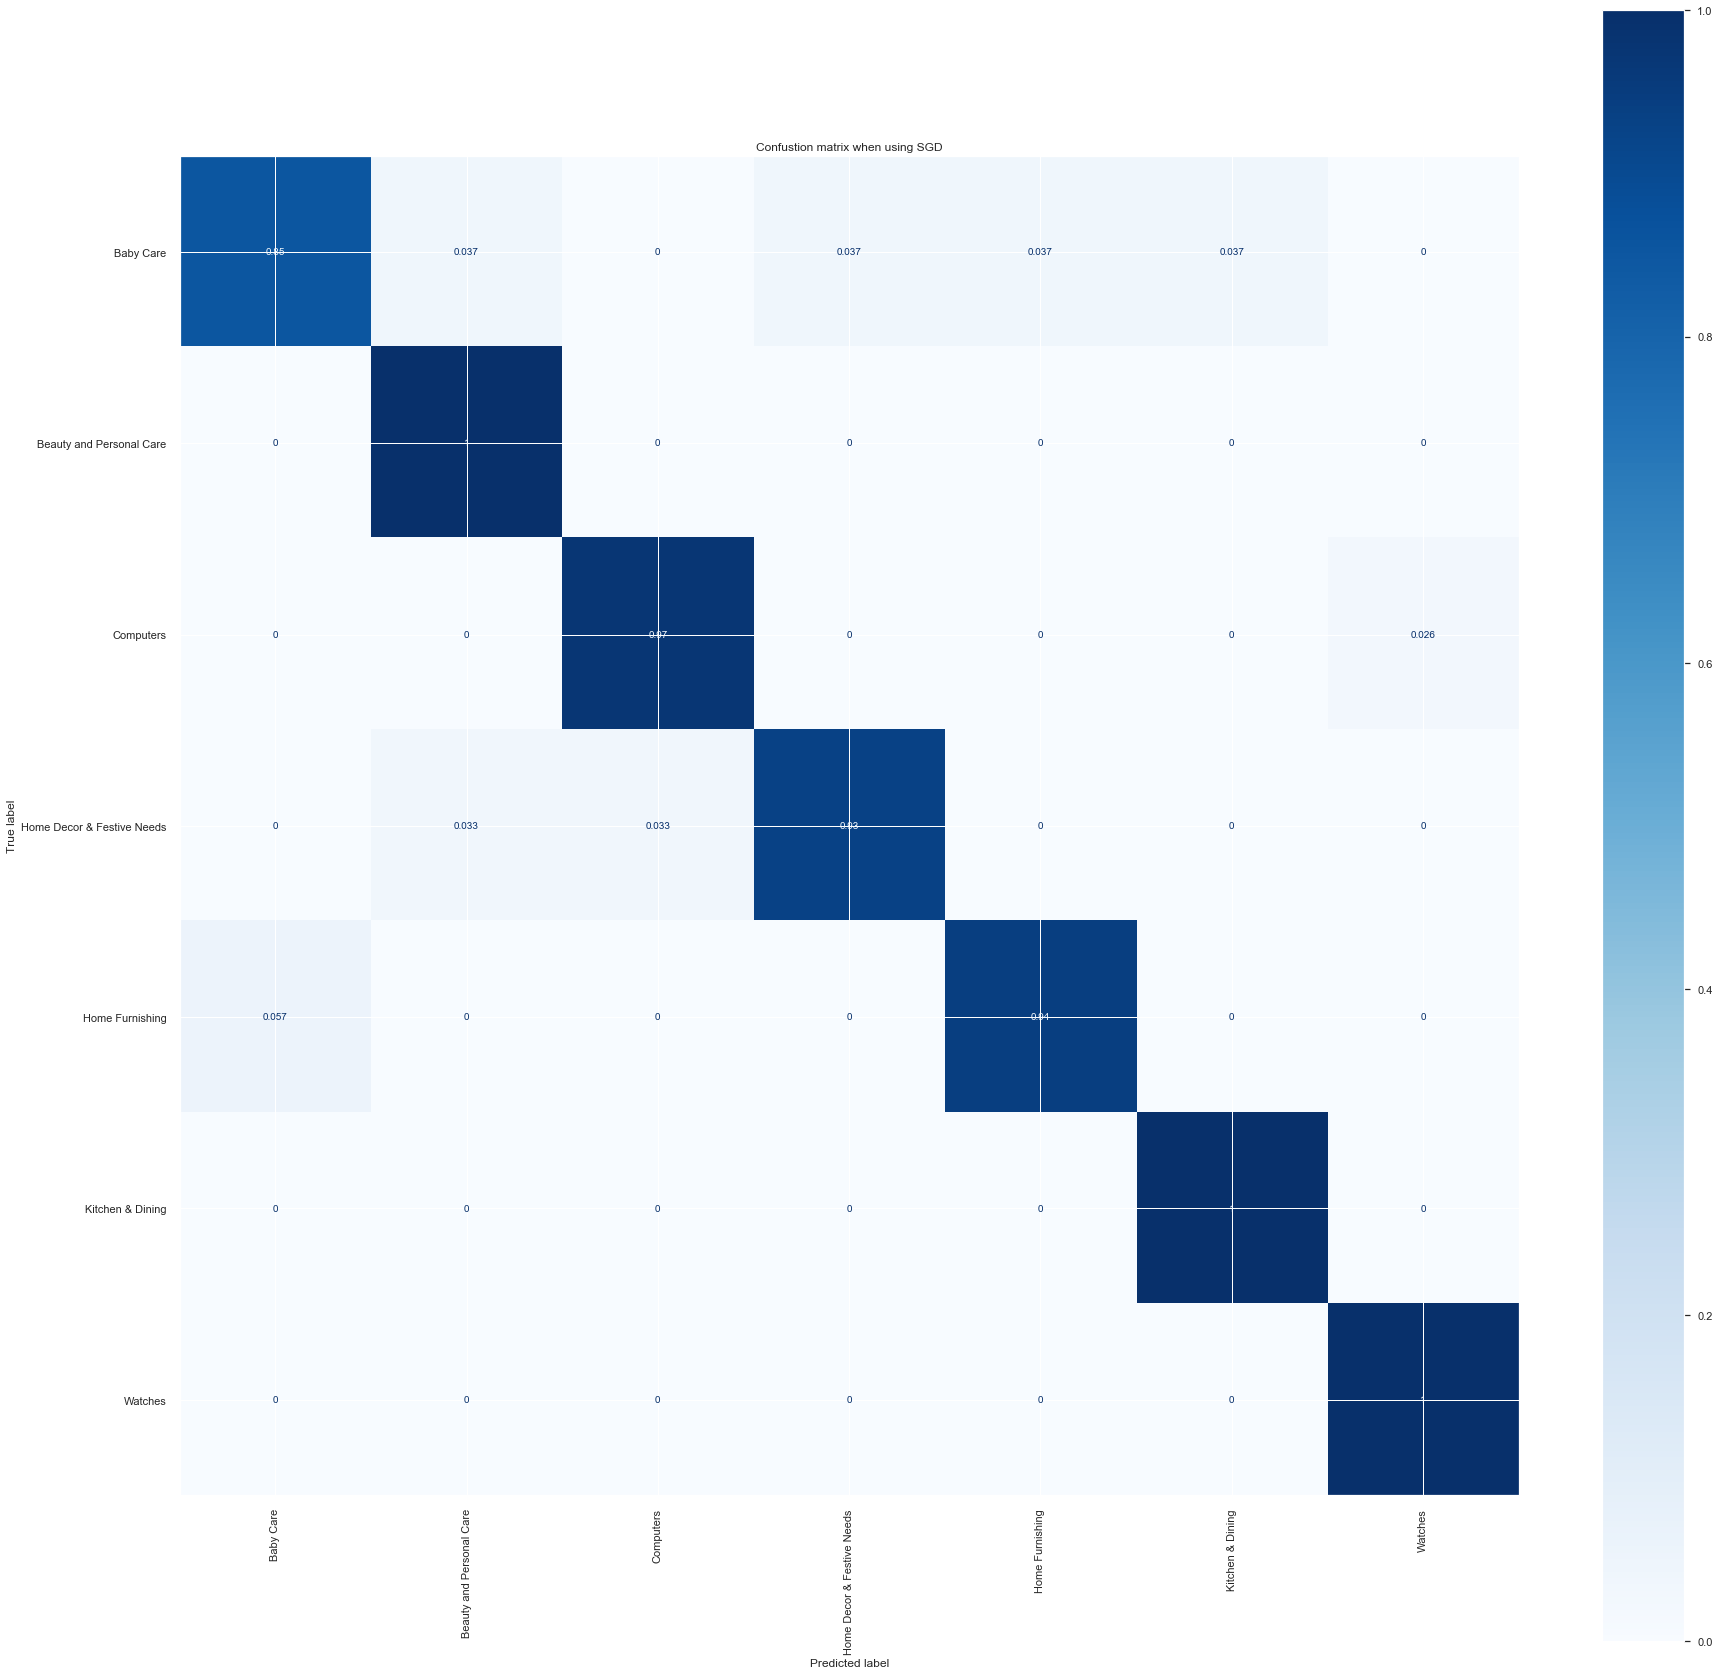

In [48]:
fig, ax = plt.subplots(figsize=(30, 30))
disp = plot_confusion_matrix(best_sgd_estimator, 
                             X_test, y_test, cmap=plt.cm.Blues,
                             normalize='true', 
                             xticks_rotation='vertical',
                             ax=ax)
disp.ax_.set_title('Confustion matrix when using SGD')
plt.show()

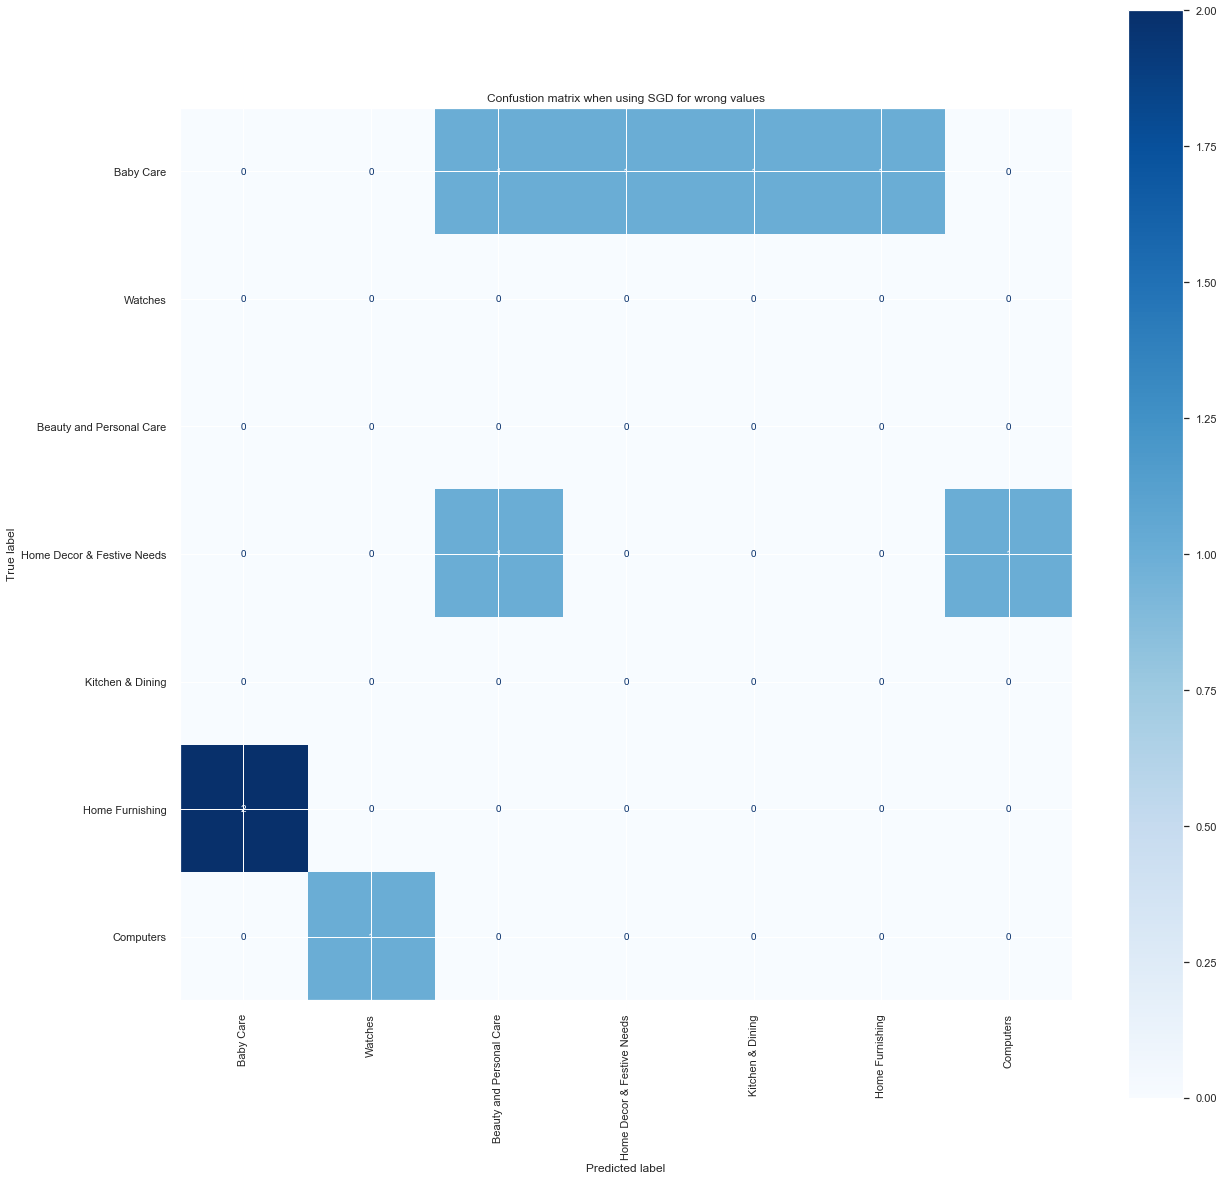

In [49]:
fig, ax = plt.subplots(figsize=(20, 20))
disp = plot_confusion_matrix(best_sgd_estimator,
                             X_test[y_pred != y_test], 
                             y_test[y_pred != y_test],
                             labels=list(set(y_test[y_pred != y_test]) | set(y_pred[y_pred != y_test])),
                             cmap=plt.cm.Blues,
                             normalize=None, 
                             xticks_rotation='vertical',
                             ax=ax)
disp.ax_.set_title('Confustion matrix when using SGD for wrong values')
plt.show()

Un dernier essai serait d'utiliser le SGD classifier avec une LDA, pour voir ce que ça donne

In [50]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lda', LatentDirichletAllocation()),
    ('clf', SGDClassifier())
])

parameters = {
    'vect__tokenizer': (stemming_tokenizer,),
    'vect__encoding': ('utf-8',),
    'vect__lowercase': (True,),
    'vect__stop_words': (stop_words, ),
    'vect__max_df': (0.7, 0.8, 0.9, 1.0),
    'vect__min_df': (0.001, 0.01, 0.1, 1),
    'vect__ngram_range': ((1, 1), ),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__early_stopping': (True,),
    'clf__penalty': ('l2', 'elasticnet'),
    'lda__n_components': (data['main category'].nunique(),)
}
        
best_sgd_lda_estimator = estimate(parameters, pipeline)

Performing grid search...
pipeline: ['vect', 'tfidf', 'lda', 'clf']
parameters:
{'vect__tokenizer': (<function stemming_tokenizer at 0x0000018455B63C18>,), 'vect__encoding': ('utf-8',), 'vect__lowercase': (True,), 'vect__stop_words': ({'a', 'com', 'each', 'be', 'whom', 'hers', 'here', 'should', 'rs', 'these', 'so', 'very', 'feature', 'or', "it's", 'itself', '}', '`', 'weren', 'over', 'y', '!', 'detail', 'himself', 'the', 'few', 'isn', "hasn't", 'deliveri', 'is', 'being', 'brand', 'most', 'yours', "that'll", 'replac', '>', 'there', "'", 'in', 'ma', "shan't", "should've", 'after', 'same', 'were', 'about', 'at', 'will', '*', '<', '[', 'yourself', '~', "shouldn't", 'you', '.', "aren't", '(', 'only', 'i', 't', 'won', 'mightn', 'flipkart', 'd', "doesn't", 'made', 'x', 'do', '"', ':', 'needn', 'during', 'than', "wouldn't", 'myself', '|', 'shouldn', ';', '\\', 'price', 'was', "don't", 'free', 'for', 'just', 'this', 'great', 'been', 'down', '?', "haven't", 'doing', 'by', 'they', 'his', 'their',

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed: 10.2min finished


done in 615.126s

Best cross validation score: 0.486
Training set score: 0.530
Testing set score: 0.514
Best parameters set:
	clf__alpha: 1e-05
	clf__early_stopping: True
	clf__max_iter: 20
	clf__penalty: 'l2'
	lda__n_components: 7
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__encoding: 'utf-8'
	vect__lowercase: True
	vect__max_df: 0.9
	vect__min_df: 0.01
	vect__ngram_range: (1, 1)
	vect__stop_words: {'a', 'com', 'each', 'be', 'whom', 'hers', 'here', 'should', 'rs', 'these', 'so', 'very', 'feature', 'or', "it's", 'itself', '}', '`', 'weren', 'over', 'y', '!', 'detail', 'himself', 'the', 'few', 'isn', "hasn't", 'deliveri', 'is', 'being', 'brand', 'most', 'yours', "that'll", 'replac', '>', 'there', "'", 'in', 'ma', "shan't", "should've", 'after', 'same', 'were', 'about', 'at', 'will', '*', '<', '[', 'yourself', '~', "shouldn't", 'you', '.', "aren't", '(', 'only', 'i', 'flipkart', 't', 'won', 'mightn', "doesn't", 'd', 'made', 'x', 'do', '"', ':', 'needn', 'during', 'than', "wouldn't", 

Notre score a bien baissé avec une LDA, on restera juste sur un TF-IDF + un SGD pour classifier le texte 